In [2]:
# Demo for visualisation of crop type and yield data
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point  # Point class
import rasterio as rio
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import os
import xarray as xr
import glob
import numpy as np
from rasterio import plot
import rasterio

import json
import re

import rioxarray as rxr
import glob
from datetime import datetime
import warnings
import pathlib
import xarray as xr
import pandas as pd
import rioxarray

ROOT_PATH_Directory = '/home/dlassahn/Dev/WorldCrops/'
data_dir = ROOT_PATH_Directory + \
    'data/cropdata/Bavaria/yields/sat_images_10m/'


def get_timestamp(meta_path):
    ''' get timestamp from meta file'''
    if Path(meta_path).exists():
        with open(meta_path, "r") as file:
            json_string = file.read()
            data = json.loads(json_string)
            date_regex = r"(\d{4}-\d{2}-\d{2})"
            date = re.search(r"TIME=" + date_regex, data['url'])

            timestamp = date.group(1)
            return datetime.strptime(timestamp, '%Y-%m-%d').date()
    else:
        return None  # or raise an exception, or return a default value


def get_directory_meta_information(data_dir):
    ''' get the meta information from a directory with fields and satellite images'''
    image_info = []

    for directory in glob.glob(os.path.join(data_dir, '*/')):
        name = os.path.basename(os.path.normpath(directory))

        # Iterate over all time series data for a field
        for _, data in enumerate(glob.glob(os.path.join(directory, '*/'))):
            image_id = os.path.basename(os.path.normpath(data))
            file = os.path.join(data, 'response.tiff')
            meta = os.path.join(data, 'request.json')

            try:
                # Check if files exist before retrieving metadata
                if Path(file).exists() and Path(meta).exists():
                    timestamp = get_timestamp(meta)
                    image_info.append((name, image_id, file, timestamp))
                else:
                    print(f"Files not found for {name}/{image_id}")

            except BaseException as error:
                print(f'An exception occurred: {error}, Image_id: {image_id}')

    return image_info

Example for yield data

In [60]:
# spatial field yield data from a combine harvester
# PVerify the current PATH with pwd if data is not found
yield_data_2018 = ROOT_PATH_Directory + \
    'data/cropdata/Bavaria/yields/yields2018.csv'
# linear interpolated mean values on a weekly basis for winter wheat. (mean values for each field and aqquisition date)
training_data = ROOT_PATH_Directory + \
    "data/cropdata/Bavaria/yields/result_split_S2A_linear_W_WW_2018.xlsx"
# not interpolated daily data
training_data_not_interpolated = ROOT_PATH_Directory + \
    "data/cropdata/Bavaria/yields/satellite_data_orginal.xlsx"
# field information
field_data = ROOT_PATH_Directory + \
    "data/cropdata/Bavaria/yields/fields_summary.xlsx"

# summary with nitrogen, yield and polygon ..."field-level yield in dt/ha !"
summary = pd.read_excel(field_data)
# yields
yields = pd.read_csv(yield_data_2018,
                     sep=",",
                     encoding="ISO-8859-1",
                     engine='python')
yields = yields[[
    'Name', 'Latitude', 'Longitude', 'Elevation(m)',
    'Ertr.masse (Nass)(tonne/ha)', 'Ertr.masse (Tr.)(tonne/ha)',
    'Ertr.vol (Tr.)(L/ha)', 'ErtragNass', 'ErtragTr', 'Feuchtigkeit(%)',
    'Jahr', 'TAG'
]]
# training data
training = pd.read_excel(training_data)
daily_training = pd.read_excel(training_data_not_interpolated)

In [4]:
# print field names
print(summary.Name.tolist())

['Baumacker', 'D2', 'D3', 'D4', 'D8', 'Dichtlacker', 'Feldhof1', 'Feldhof1a', 'Feldhof1b', 'Feldhof2', 'Grafenfeld', 'Heindlacker', 'Heng', 'Holzacker', 'Itzling2', 'Itzling4', 'Itzling5', 'Itzling6', 'Krohberg', 'Muehlacker', 'Neulandsiedlung', 'Radarstation', 'Schluetterfabrik', 'Sieblerfeld', 'Striegelfeld', 'Thalhausen138', 'Thalhausen141', 'Thalhausen86', 'Viehhausen1', 'Viehhausen11', 'Viehhausen3', 'Viehhausen5', 'Voettingerfeld']


Plot timeseries from training data and corresponding field borders and yield data

Pixel-based yield and satellite data

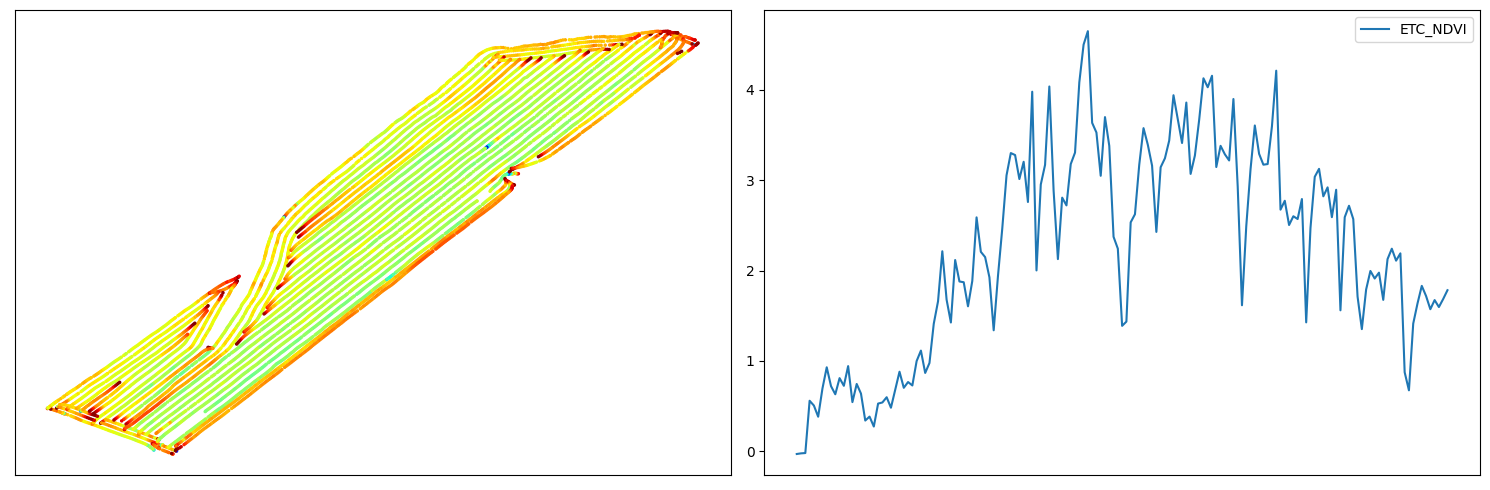

In [5]:
def plot_data(field_name, yield_data, training_data, label):
    ''' 
    plot the corresponding combine harvester data for a field

    Parameters:
    field_name (string): name of the field
    yield_data (dataframe):
    training_data (dataframe):
    label (string): name of column in training_data which should be visualized

    Returns:
    Visualisation with the field and the corresponding data
    '''

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    field = yield_data[yield_data.Name == field_name]
    geometry = [Point(xy) for xy in zip(field.Longitude, field.Latitude)]
    crs = {'init': 'epsg:4326'}
    # gdf = gpd.GeoDataFrame(field, crs=crs, geometry=geometry)
    # gdf.plot(ax=ax1)

    ax1.scatter(y=field.Latitude,
                x=field.Longitude,
                alpha=1,
                cmap=plt.get_cmap("jet_r"),
                c=field['Ertr.masse (Nass)(tonne/ha)'],
                s=2.2)
    training_data[training_data.Name == field_name][[label]].plot(ax=ax2)

    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2.axes.get_xaxis().set_visible(False)
    # ax2.axes.get_yaxis().set_visible(False)

    f.tight_layout()
    plt.show()


plot_data(field_name='Heindlacker',
          yield_data=yields,
          training_data=daily_training,
          label='ETC_NDVI')

In [6]:
from xarray import Dataset
import rioxarray
import warnings
from functools import wraps
# AGRICULTURE_L2A_GAN ->sat_images_10m
# AGRICULTURE_L2A_GAN ->sat_images_meta
# sample.CLM, sample.dataMask, sample.B01, sample.B02,sample.B03,sample.B04,sample.B05,sample.B06,sample.B07,sample.B08,sample.B8A,sample.B09,sample.B11,sample.B12,sample.sunAzimuthAngles,sample.sunZenithAngles,sample.viewAzimuthMean,sample.viewZenithMean, ndwi]

# AGRICULTURE_L2A ->sat_images
# sample.CLM, ndvi, ndwi, sample.B01, sample.B02,sample.B03,sample.B04,sample.B05,sample.B06,sample.B07,sample.B08,sample.B8A,sample.B09,sample.B11,sample.B12

# welche DAten hat Vikotr verwendet ?
# glaub die 10m..sind die aktuellesten

import sys


def suppress_stderr(func):

    def wrapper(*args, **kwargs):
        # Redirect stderr to null
        with open(os.devnull, 'w') as devnull:
            original_stderr = sys.stderr
            sys.stderr = devnull
            try:
                result = func(*args, **kwargs)
            finally:
                sys.stderr = original_stderr
        return result

    return wrapper


def suppress_warnings(warning_type, message):

    def decorator(func):

        @wraps(func)
        def wrapper(*args, **kwargs):
            with warnings.catch_warnings(record=True) as w:
                warnings.filterwarnings("ignore",
                                        category=warning_type,
                                        message=message)
                result = func(*args, **kwargs)
                # Print suppressed warnings if needed
                for warning in w:
                    print(f"Suppressed Warning: {warning.message}")
            return result

        return wrapper

    return decorator

In [26]:
from collections import defaultdict
import sys

metadata = get_directory_meta_information(data_dir)
field_data_arrays = {}


# @suppress_warnings(UserWarning, ".*TIFFReadDirectory.*")
@suppress_stderr
def create_xarray_dataset(metadata_list):
    # Group metadata by field
    grouped_metadata = defaultdict(list)
    for item in metadata_list:
        field = item[0]
        grouped_metadata[field].append(item)

    # Dictionary to hold DataArray for each field

    for field, metadata in grouped_metadata.items():
        time_series = []

        for i, (field, image_id, file_path, date) in enumerate(metadata):
            # Read and process raster data
            data_array = rioxarray.open_rasterio(file_path, masked=True)
            data_array = data_array.sel(
                band=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 19])

            # print(data_array.rio.crs)

            # Define coordinates
            x_coord = data_array.x
            y_coord = data_array.y
            time_coord = pd.to_datetime(date)  # Scalar value for time

            # Create DataArray with additional scalar coordinate for time
            temp_array = xr.DataArray(data_array,
                                      coords={
                                          'band': data_array.band,
                                          'x': x_coord,
                                          'y': y_coord,
                                          'time': time_coord
                                      },
                                      dims=data_array.dims)

            # Assign 'time' as a scalar coordinate, not a dimension
            temp_array = temp_array.assign_coords(time=time_coord)

            time_series.append(temp_array)

        # Sort the time_series by 'time' before concatenating

        ts_sorted = sorted(time_series, key=lambda x: x.coords['time'].values)

        # Concatenate along the time dimension
        field_data_arrays[field] = xr.concat(ts_sorted, dim='time')

    # Combine into a single Dataset
    # ds = xr.Dataset(field_data_arrays)

    return field_data_arrays


# Create the dataset using the adapted function
xarray_dataset = create_xarray_dataset(metadata)
# xarray_dataset2 = create_xarray_dataset(metadata[13:24])

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

In [27]:
xarray_dataset['Striegelfeld']

<xarray.DataArray (time: 12, band: 13, y: 28, x: 19)>
array([[[[ 0.        ,  0.        ,  0.        , ...,  0.0054    ,
           0.0054    ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.0054    ,
           0.0054    ,  0.        ],
         [ 0.        ,  0.0066    ,  0.008     , ...,  0.0054    ,
           0.0054    ,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.0209    ,
           0.0202    ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.0221    ,
           0.0145    ,  0.        ],
         [ 0.        ,  0.0116    ,  0.0126    , ...,  0.0159    ,
           0.013     ,  0.        ],
...
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.0482585 ,
           0.14640573,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.01476977,
           0.10971541,  0.        ],
         [ 0.        ,  0.19661222,  0.10625121, ..., -0.06420852,
           0.00277998,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]]]], dtype=float32)
Coordinates:
  * band     (band) int64 3 4 5 6 7 8 9 10 11 12 13 14 19
  * x        (x) float64 1.301e+06 1.301e+06 1.301e+06 ... 1.301e+06 1.301e+06
  * y        (y) float64 6.18e+06 6.18e+06 6.18e+06 ... 6.18e+06 6.18e+06
  * time     (time) datetime64[ns] 2018-03-08 2018-04-07 ... 2018-07-26
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

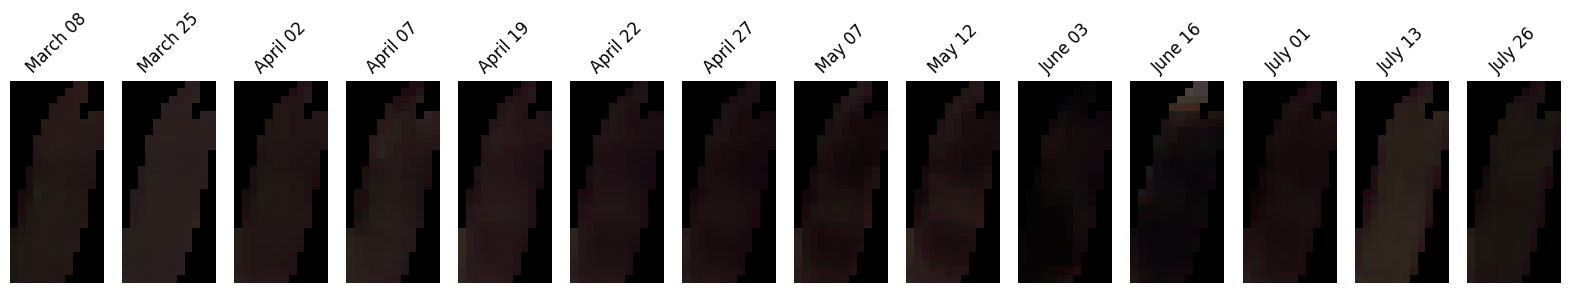

In [29]:
import matplotlib.pyplot as plt


def plot_field_images(dataset, field_name):
    field_data = dataset[field_name]
    num_time_points = field_data.sizes['time']

    fig, axs = plt.subplots(1, num_time_points, figsize=(20, 5))

    for i in range(num_time_points):
        # Extract RGB bands
        red = field_data.isel(time=i).isel(band=4)
        green = field_data.isel(time=i).isel(band=3)
        blue = field_data.isel(time=i).isel(band=2)

        # Stack bands into an RGB image
        rgb = np.stack([red, green, blue], axis=-1)
        time_formatted = pd.to_datetime(
            field_data.time.values[i]).strftime('%B %d')

        axs[i].imshow(rgb)
        axs[i].set_title(f"{time_formatted}", rotation=45)
        axs[i].axis('off')

    plt.show()


# plot_field_images_rgb(dataset, 'my_field', band_indices=[3, 2, 1])  # Example band indices

# Example usage
# Assuming 'dataset' is your xarray Dataset and 'my_field' is the field you want to visualize
plot_field_images(xarray_dataset, 'Feldhof2')

In [77]:
temp = daily_training.set_index('date')
temp

,Unnamed: 0,Name,Ertrag,Month,Jahr,ETC_NDVI,ETC_REIP,ETC_NDRE,ETC_NDWI,ETC_NDVI_norm,...,delta_diff_etc_ndvi,delta_diff_etc_ndre,delta_diff_etc_ndwi,delta_diff_etc_reip,delta_diff_etc_ndvi_norm,delta_diff_etc_ndre_norm,delta_diff_etc_ndwi_norm,delta_diff_etc_reip_norm,CUM_ETC_NDVI_norm,cum_rain
date,,,,,,,,,,,,,,,,,,,,,
2018-03-01,1937,Baumacker,90.0,3,2018,-0.010482,846.786671,-0.034891,0.825820,0.056311,...,-0.010482,-0.034891,0.825820,846.786671,0.056311,0.043562,1.111303,0.421761,0.056311,0.0
2018-03-02,1938,Baumacker,90.0,3,2018,-0.007886,637.040126,-0.026249,0.621267,0.042363,...,-0.007886,-0.026249,0.621267,637.040126,0.042363,0.032772,0.836037,0.317292,0.098673,0.0
2018-03-03,1939,Baumacker,90.0,3,2018,-0.006609,533.900296,-0.021999,0.520681,0.035504,...,-0.306609,-0.321999,0.220681,533.600296,-0.264496,-0.272534,0.400678,-0.034079,0.134177,0.3
2018-03-04,1940,Baumacker,90.0,3,2018,0.477468,782.340619,0.258575,0.106442,0.611936,...,0.177468,-0.041425,-0.193558,782.040619,0.311936,0.131986,0.087646,0.165418,0.746113,0.6
2018-03-05,1941,Baumacker,90.0,3,2018,0.432016,707.865764,0.233960,0.096310,0.553682,...,0.432016,0.233960,0.096310,707.865764,0.553682,0.390863,0.350744,0.421112,1.299795,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-27,25659,Voettingerfeld,80.0,7,2018,2.007801,3178.334043,1.393959,-0.070246,2.558466,...,1.707801,1.093959,-0.370246,3178.034043,2.258466,1.891276,0.733389,1.569992,387.137378,321.4
2018-07-28,25660,Voettingerfeld,80.0,7,2018,2.136181,3381.557842,1.483089,-0.074738,2.722055,...,1.336181,0.683089,-0.874738,3380.757842,1.922055,1.531387,0.299464,1.189560,389.859433,322.2
2018-07-29,25661,Voettingerfeld,80.0,7,2018,2.038195,3226.447098,1.415060,-0.071310,2.597195,...,2.038195,1.415060,-0.071310,3226.447098,2.597195,2.224447,1.049032,1.898299,392.456628,322.2


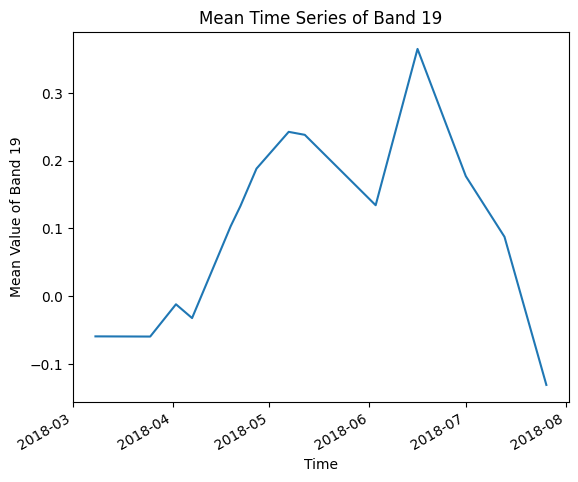

<AxesSubplot:xlabel='date'>

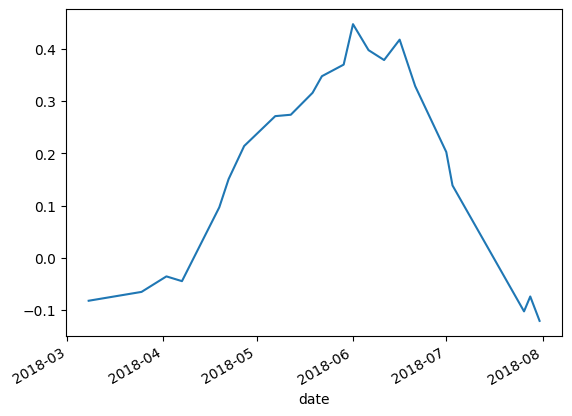

In [80]:
def plot_mean_time_series(data_array):
    # Select the specific band (band 19 in this case) from the DataArray
    selected_band = data_array.sel(band=19)

    # Calculate the mean across all dimensions, except 'time'
    # This will give the average value of the selected band over time
    mean_time_series = selected_band.mean(
        dim=[dim for dim in selected_band.dims if dim != 'time'])

    # Plot the time series
    mean_time_series.plot()
    plt.title('Mean Time Series of Band 19')
    plt.xlabel('Time')
    plt.ylabel('Mean Value of Band 19')
    plt.show()


# Assuming 'data_array' is your xarray DataArray with a 'time' dimension
plot_mean_time_series(xarray_dataset['Dichtlacker'])

temp[temp.Name == 'Dichtlacker']['NDWI_mean'].dropna().plot()

In [88]:
print(temp[temp.Name == 'Dichtlacker']['NDWI_mean'].dropna())

data_array = xarray_dataset['Dichtlacker']
selected_band = data_array.sel(band=19)
mean_time_series = selected_band.mean(
    dim=[dim for dim in selected_band.dims if dim != 'time'])
mean_time_series.name = 'teest'

date
2018-03-08   -0.082577
2018-03-25   -0.065600
2018-04-02   -0.035852
2018-04-07   -0.045008
2018-04-19    0.096605
2018-04-22    0.150742
2018-04-27    0.214180
2018-05-07    0.271507
2018-05-12    0.274172
2018-05-19    0.316243
2018-05-22    0.348097
2018-05-29    0.370291
2018-06-01    0.447907
2018-06-06    0.398047
2018-06-11    0.379105
2018-06-16    0.418213
2018-06-21    0.329024
2018-07-01    0.202615
2018-07-03    0.138591
2018-07-26   -0.102976
2018-07-28   -0.074394
2018-07-31   -0.121206
Name: NDWI_mean, dtype: float64


<AxesSubplot:xlabel='date'>

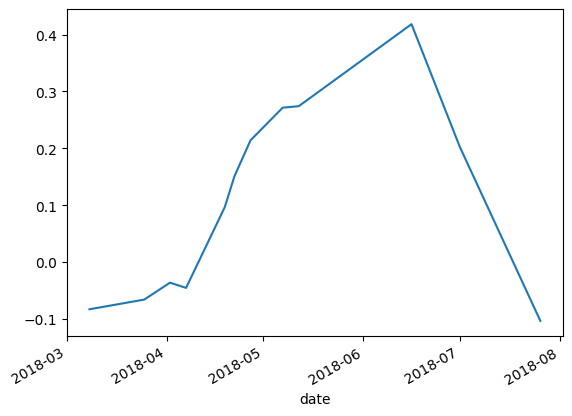

In [103]:
df = mean_time_series.to_dataframe()['teest']
df2 = temp[temp.Name == 'Dichtlacker']['NDWI_mean'].dropna()

df.index
df2.index  # hat mehr

filtered_df = df2[df2.index.isin(df.index)]
filtered_df.plot()

In [132]:
# every image has 19 bands with 66 x 31 pixels
# time_interval:'2018-03-01' - '2018-07-30'
# Level L2A
# Winter Wheat: 'Baumacker', 'D8', 'Dichtlacker', 'Heindlacker', 'Heng', 'Holzacker', 'Neulandsiedlung', 'Itzling2', 'Itzling5',
# 'Itzling6', 'Schluetterfabrik','Thalhausen138', 'Thalhausen141', 'Voettingerfeld'
#
# Image bands:
# ["CLM", "dataMask", "B01", "B02", "B03", "B04","B05", "B06","B07", "B08","B8A", "B09", "B11","B12", sunAzimuthAngles, sunZenithAngles, viewAzimuthMean, viewZenithMean, NDWI]
# CLM stands for clouds 1 / no clouds 0
# there are also meta information and an index
from torch.utils.data import TensorDataset
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

import numpy as np

# Assuming you have an xarray DataArray
numpy_array = xarray_dataset['Dichtlacker'].values
labels = yields[yields.Name ==
                'Dichtlacker']['Ertr.masse (Tr.)(tonne/ha)'].values

tensor_data = torch.from_numpy(numpy_array.astype(np.float32))

# Assuming tensor_data is your features and tensor_labels are your labels
tensor_labels = torch.from_numpy(labels.astype(np.float32))

# Create a TensorDataset
dataset = TensorDataset(tensor_data)

In [135]:
# zu tun labels müssen zu features passen. das ist etwas komplexer.
# was tun ?
# 1. erstmal die repo testen und cleaning beenden.
# 2. Beispiel von viktor durchgehen bevor ich das selbst angehe ?
geometry[:]

 ...]